Importing Libraries

In [4]:
#importing libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split,DataLoader
import torch.optim as optim



Loading Datasets

In [5]:
# setting file path
train_filepath = "../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
test_filepath = "../input/asl-alphabet/asl_alphabet_test"

In [6]:
# defining transforms
train_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
#Data Loading 
train_dataset = datasets.ImageFolder(train_filepath, transform=train_transforms)
print("Train Dataset Info:\n")
train_dataset

Train Dataset Info:



Dataset ImageFolder
    Number of datapoints: 87000
    Root location: ../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

#### DataLoader
DataLoader takes a dataset (such as you would get from ImageFolder) and returns batches of images and the corresponding labels.

In [8]:

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=64, 
                                               shuffle=True,
                                               num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
train_label = train_dataloader.dataset.classes
print("Labels :\t",train_label,"\nLength of the label list :",len(train_label))

Labels :	 ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'] 
Length of the label list : 29


In [11]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# data, labels = data.to(device), labels.to(device)

In [42]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.NN = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2)
        )

        self.predict = nn.Sequential(
            nn.Linear(16*100*100,100),
            nn.Dropout(0.2),
            nn.BatchNorm1d(100),
            nn.Dropout(0.2),
            nn.Linear(100,29),
            nn.Softmax(dim=1)
        )
    
    def forward(self,x):
        x = self.NN(x)
        x = x.view(-1,16*100*100)
        return self.predict(x)


In [43]:
#creating a model 
model = NN()

if torch.cuda.is_available():
    model.cuda()
    
model

NN(
  (NN): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (predict): Sequential(
    (0): Linear(in_features=160000, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=100, out_features=29, bias=True)
    (5): Softmax(dim=1)
  )
)

In [44]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [47]:
num_epochs = 5
for epoch in range(num_epochs):
    correct = 0
    for batch_idx , (data,labels) in enumerate(train_dataloader):
        data = data.to(device=device)
        labels = labels.to(device= device)
        data, labels = data.cuda(), labels.cuda()
        
        #forward
        scores = model(data)
        loss = criterion(scores, labels)

        #backprop
        optimizer.zero_grad()
        loss.backward()

        #gradient descent
        optimizer.step()

        #performance
        prediction = torch.max(scores,1)[1]
    
        correct += (prediction == labels).cpu().sum().numpy()

    print("Epoch :",epoch,"\tLoss :",loss.data,"\tAccuracy :",(correct/len(train_dataloader.dataset))*100)        

Epoch : 0 	Loss : tensor(2.7237, device='cuda:0') 	Accuracy : 72.00919540229886
Epoch : 1 	Loss : tensor(2.6790, device='cuda:0') 	Accuracy : 72.82758620689656
Epoch : 2 	Loss : tensor(2.6650, device='cuda:0') 	Accuracy : 73.5735632183908
Epoch : 3 	Loss : tensor(2.5847, device='cuda:0') 	Accuracy : 74.31954022988506
Epoch : 4 	Loss : tensor(2.7817, device='cuda:0') 	Accuracy : 75.38850574712643


In [49]:
model1 = NN()

if torch.cuda.is_available():
    model1.cuda()
    
model1

NN(
  (NN): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (predict): Sequential(
    (0): Linear(in_features=160000, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=100, out_features=29, bias=True)
    (5): Softmax(dim=1)
  )
)

In [50]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr= 0.01, weight_decay = 0.0001)

In [51]:
num_epochs = 5
for epoch in range(num_epochs):
    correct = 0
    for batch_idx , (data,labels) in enumerate(train_dataloader):
        data = data.to(device=device)
        labels = labels.to(device= device)
        data, labels = data.cuda(), labels.cuda()
        
        #forward
        scores = model1(data)
        loss = criterion(scores, labels)

        #backprop
        optimizer.zero_grad()
        loss.backward()

        #gradient descent
        optimizer.step()

        #performance
        prediction = torch.max(scores,1)[1]
    
        correct += (prediction == labels).cpu().sum().numpy()

    print("Epoch :",epoch,"\tLoss :",loss.data,"\tAccuracy :",(correct/len(train_dataloader.dataset))*100)   

Epoch : 0 	Loss : tensor(3.0779, device='cuda:0') 	Accuracy : 47.72758620689655
Epoch : 1 	Loss : tensor(3.0456, device='cuda:0') 	Accuracy : 40.217241379310344
Epoch : 2 	Loss : tensor(2.9844, device='cuda:0') 	Accuracy : 46.16551724137931
Epoch : 3 	Loss : tensor(2.9071, device='cuda:0') 	Accuracy : 49.55172413793104
Epoch : 4 	Loss : tensor(2.9064, device='cuda:0') 	Accuracy : 52.79655172413793


****Kernel = 3, 1 Layer CNN****

In [55]:
class NN1(nn.Module):
    def __init__(self):
        super(NN1,self).__init__()
        self.NN = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(16,32,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2)
        )

        self.predict = nn.Sequential(
            nn.Linear(32*50*50,200),
            nn.Dropout(0.2),
            nn.BatchNorm1d(200),
            nn.Dropout(0.2),
            nn.Linear(200,29),
            nn.Softmax(dim=1)
        )
    
    def forward(self,x):
        x = self.NN(x)
        x = x.view(-1,32*50*50)
        return self.predict(x)

**Kernel = 3, 2 Layer CNN**

In [56]:
model2 = NN1()

if torch.cuda.is_available():
    model2.cuda()
    
model2

NN1(
  (NN): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (predict): Sequential(
    (0): Linear(in_features=80000, out_features=200, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=200, out_features=29, bias=True)
    (5): Softmax(dim=1)
  )
)

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr= 0.01, weight_decay = 0.0001)

In [60]:
num_epochs = 5
for epoch in range(num_epochs):
    correct = 0
    for batch_idx , (data,labels) in enumerate(train_dataloader):
        data = data.to(device=device)
        labels = labels.to(device= device)
        data, labels = data.cuda(), labels.cuda()
        
        #forward
        scores = model2(data)
        loss = criterion(scores, labels)

        #backprop
        optimizer.zero_grad()
        loss.backward()

        #gradient descent
        optimizer.step()

        #performance
        prediction = torch.max(scores,1)[1]
    
        correct += (prediction == labels).cpu().sum().numpy()

    print("Epoch :",epoch,"\tLoss :",loss.data,"\tAccuracy :",(correct/len(train_dataloader.dataset))*100)

Epoch : 0 	Loss : tensor(3.0284, device='cuda:0') 	Accuracy : 29.27126436781609
Epoch : 1 	Loss : tensor(2.8289, device='cuda:0') 	Accuracy : 44.327586206896555
Epoch : 2 	Loss : tensor(2.9116, device='cuda:0') 	Accuracy : 51.272413793103446
Epoch : 3 	Loss : tensor(2.9135, device='cuda:0') 	Accuracy : 54.14367816091954
Epoch : 4 	Loss : tensor(2.9322, device='cuda:0') 	Accuracy : 55.880459770114946


In [12]:
class NN3(nn.Module):
    def __init__(self):
        super(NN3,self).__init__()
        self.NN3 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,stride=1,padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2)
        )

        self.predict = nn.Sequential(
            nn.Linear(256*25*25,200),
            nn.Dropout(0.5),
            nn.BatchNorm1d(200),
            nn.Dropout(0.2),
            nn.Linear(200,29),
            nn.Softmax(dim=1)
        )
    
    def forward(self,x):
        x = self.NN3(x)
        x = x.view(-1,256*25*25)
        return self.predict(x)     
        

**Kernel = 3, 3 Layer CNN**

In [13]:
model3 = NN3()

if torch.cuda.is_available():
    model3.cuda()
    
model3

NN3(
  (NN3): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (predict): Sequential(
    (0): Linear(in_features=160000, out_features=200, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): BatchNorm1d(200, eps=1e-0

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr= 0.001)

In [18]:
num_epochs = 5
for epoch in range(num_epochs):
    correct = 0
    for batch_idx , (data,labels) in enumerate(train_dataloader):
        data = data.to(device=device)
        labels = labels.to(device= device)
        data, labels = data.cuda(), labels.cuda()
        
        #forward
        scores = model3(data)
        loss = criterion(scores, labels)

        #backprop
        optimizer.zero_grad()
        loss.backward()

        #gradient descent
        optimizer.step()

        #performance
        prediction = torch.max(scores,1)[1]
    
        correct += (prediction == labels).cpu().sum().numpy()

    print("Epoch :",epoch,"\tLoss :",loss.data,"\tAccuracy :",(correct/len(train_dataloader.dataset))*100)

Epoch : 0 	Loss : tensor(2.4532, device='cuda:0') 	Accuracy : 97.4655172413793
Epoch : 1 	Loss : tensor(2.4290, device='cuda:0') 	Accuracy : 98.73908045977011
Epoch : 2 	Loss : tensor(2.4309, device='cuda:0') 	Accuracy : 98.99195402298851
Epoch : 3 	Loss : tensor(2.4434, device='cuda:0') 	Accuracy : 99.17011494252873
Epoch : 4 	Loss : tensor(2.4252, device='cuda:0') 	Accuracy : 99.32528735632184


**Kernel = 5, 3 Layer CNN**

In [19]:
class NN5(nn.Module):
    def __init__(self):
        super(NN5,self).__init__()
        self.NN5 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=5,stride=1,padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(64,128,kernel_size=5,stride=1,padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(128,256,kernel_size=5,stride=1,padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2)
        )

        self.predict = nn.Sequential(
            nn.Linear(256*25*25,200),
            nn.Dropout(0.5),
            nn.BatchNorm1d(200),
            nn.Dropout(0.5),
            nn.Linear(200,29),
            nn.Softmax(dim=1)
        )
    
    def forward(self,x):
        x = self.NN5(x)
        x = x.view(-1,256*25*25)
        return self.predict(x)  

In [20]:
model5 = NN5()

if torch.cuda.is_available():
    model5.cuda()
    
model5

NN5(
  (NN5): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (predict): Sequential(
    (0): Linear(in_features=160000, out_features=200, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): BatchNorm1d(200, eps=1e-0

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr= 0.001, weight_decay=0.0001)

In [23]:
num_epochs = 5
for epoch in range(num_epochs):
    correct = 0
    for batch_idx , (data,labels) in enumerate(train_dataloader):
        data = data.to(device=device)
        labels = labels.to(device= device)
        data, labels = data.cuda(), labels.cuda()
        
        #forward
        scores = model5(data)
        loss = criterion(scores, labels)

        #backprop
        optimizer.zero_grad()
        loss.backward()

        #gradient descent
        optimizer.step()

        #performance
        prediction = torch.max(scores,1)[1]
    
        correct += (prediction == labels).cpu().sum().numpy()

    print("Epoch :",epoch,"\tLoss :",loss.data,"\tAccuracy :",(correct/len(train_dataloader.dataset))*100)

Epoch : 0 	Loss : tensor(2.7647, device='cuda:0') 	Accuracy : 51.68505747126437
Epoch : 1 	Loss : tensor(2.5223, device='cuda:0') 	Accuracy : 86.1551724137931
Epoch : 2 	Loss : tensor(2.4674, device='cuda:0') 	Accuracy : 92.5
Epoch : 3 	Loss : tensor(2.5570, device='cuda:0') 	Accuracy : 93.91724137931034
Epoch : 4 	Loss : tensor(2.5963, device='cuda:0') 	Accuracy : 94.41034482758621


In [31]:
class NN5NN(nn.Module):
    def __init__(self):
        super(NN5NN,self).__init__()
        self.NN5NN = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=1,padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2)
        )

        self.predict = nn.Sequential(
            nn.Linear(256*25*25,200),
            nn.Dropout(0.5),
            nn.BatchNorm1d(200),
            nn.Dropout(0.5),
            nn.Linear(200,29),
            nn.Softmax(dim=1)
        )
    
    def forward(self,x):
        x = self.NN5NN(x)
        x = x.view(-1,256*25*25)
        return self.predict(x)

***5 Layer CNN***

In [32]:
model5N = NN5NN()

if torch.cuda.is_available():
    model5N.cuda()
    
model5N

NN5NN(
  (NN5NN): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5N.parameters(), lr= 0.001, weight_decay=0.0001)

In [34]:
num_epochs = 5
for epoch in range(num_epochs):
    correct = 0
    for batch_idx , (data,labels) in enumerate(train_dataloader):
        data = data.to(device=device)
        labels = labels.to(device= device)
        data, labels = data.cuda(), labels.cuda()
        
        #forward
        scores = model5N(data)
        loss = criterion(scores, labels)

        #backprop
        optimizer.zero_grad()
        loss.backward()

        #gradient descent
        optimizer.step()

        #performance
        prediction = torch.max(scores,1)[1]
    
        correct += (prediction == labels).cpu().sum().numpy()

    print("Epoch :",epoch,"\tLoss :",loss.data,"\tAccuracy :",(correct/len(train_dataloader.dataset))*100)

Epoch : 0 	Loss : tensor(2.7494, device='cuda:0') 	Accuracy : 57.59655172413793
Epoch : 1 	Loss : tensor(2.5944, device='cuda:0') 	Accuracy : 85.22298850574713
Epoch : 2 	Loss : tensor(2.4658, device='cuda:0') 	Accuracy : 91.41034482758621
Epoch : 3 	Loss : tensor(2.5118, device='cuda:0') 	Accuracy : 93.02873563218391
Epoch : 4 	Loss : tensor(2.4902, device='cuda:0') 	Accuracy : 93.52068965517242


***DATASET***

In [24]:
import os
import cv2
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

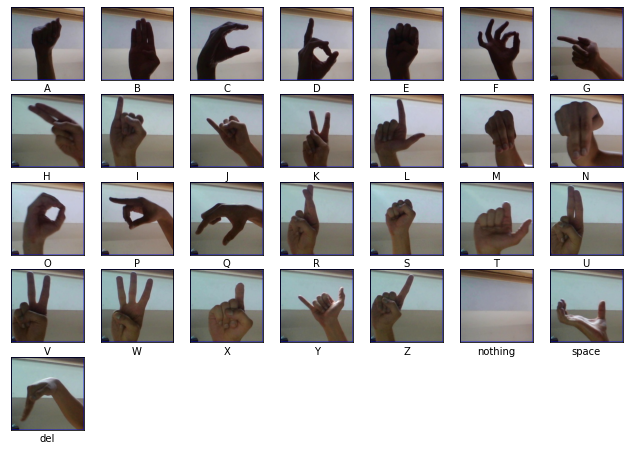

In [25]:
train_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_dir = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']
plt.figure(figsize=(11, 11))
for i in range (0,29):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_dir + "/{0}/{0}1.jpg".format(classes[i])
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(classes[i])